# IFU Data Modeling, NGC 4151 Notebook #1 - Isolating Line Emission
#### This notebook uses an example 3-D IFU Datacube of the Active Galactic Nucleii NGC 4151 (Storchi-Bergmann et al. 2009,  MNRAS, V 394, pp. 1148-1166).  This is a ground-based AO-fed H-band dataset (1.47-1.87um) from the Near-Infrared Integral Field Spectrograph (NIFS) instrument at the Gemini Observatory.  NIFS is a very similar image slicing IFU to JWST NIRSpec.
In this notebook, we do some simple spectral investigations.  Then we fit the continuum in a region near to our emission feature of interest, the 1.644um [Fe II] emission from the AGN outflow.  We subtract the continuum and fit and remove the centrally compact atomic Hydrogen Brackett 12 feature, which is nearby in wavelength and contaminates the [Fe II] outflow emission.  We save data sub-cubes of the continuum model and the isolated and continuum subtracted [Fe II] emission.  These saved data sets serve as starting points for the further notebooks in this series.


In [19]:
# load important packages
import time

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy import units as u
from astropy.modeling import models
from specutils.fitting import fit_lines
from astropy.utils.data import download_file

from specutils import Spectrum1D

from jdaviz.app import Application


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})


<IPython.core.display.Javascript object>


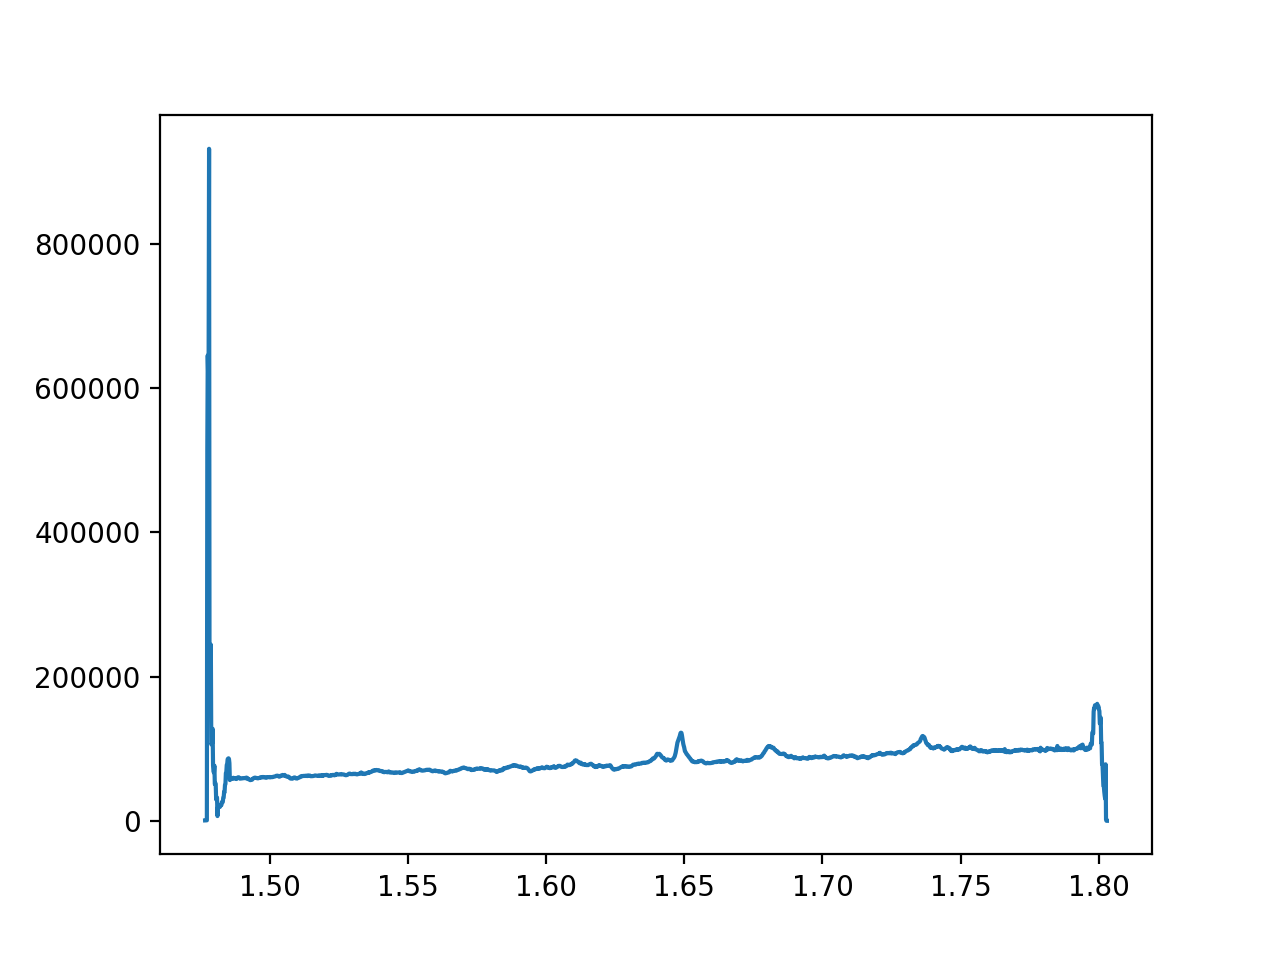

In [3]:
# Read in a 3-D IFU datacube of interest, and header.
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
cube = fits.getdata(cube_file)
header_cube = fits.getheader(cube_file)

#grab data information and wavelength definitions.
nz, ny, nx = cube.shape
crdelt3 = header_cube['CDELT3']
crval3 = header_cube['CRVAL3']

#define the wavelength grid (microns) from the header (Angstroms)
# and the AGN redshift, emission lines of interest and their indices.
wave =((crdelt3 * (np.arange(0,nz,1))) + crval3)/10000.0
redshift = 0.00332
emission_line = 1.64400*(1 + redshift)
emission_line_index = (np.abs(wave-emission_line)).argmin()

# make a simple summed 1d spectrum of the full cube
flux1 = np.sum(cube, axis=(1,2))

# plot the full 1-D spectrum.
plt.figure(0)
plt.plot(wave,flux1)
plt.show()


We see that the spectral edges of the summed 1D are 'ratty'.  The 1D spectral array goes beyond the nominal useable data range of the instrument.  We'll ignore the poor spectral regions and focus on the AGN flux.

The [Fe II] feature that we are interested in is the bright, strong emission just shortward of 1.65um.  The contaminating H I Br 12 emission is just blueward of the [Fe II].

<IPython.core.display.Javascript object>


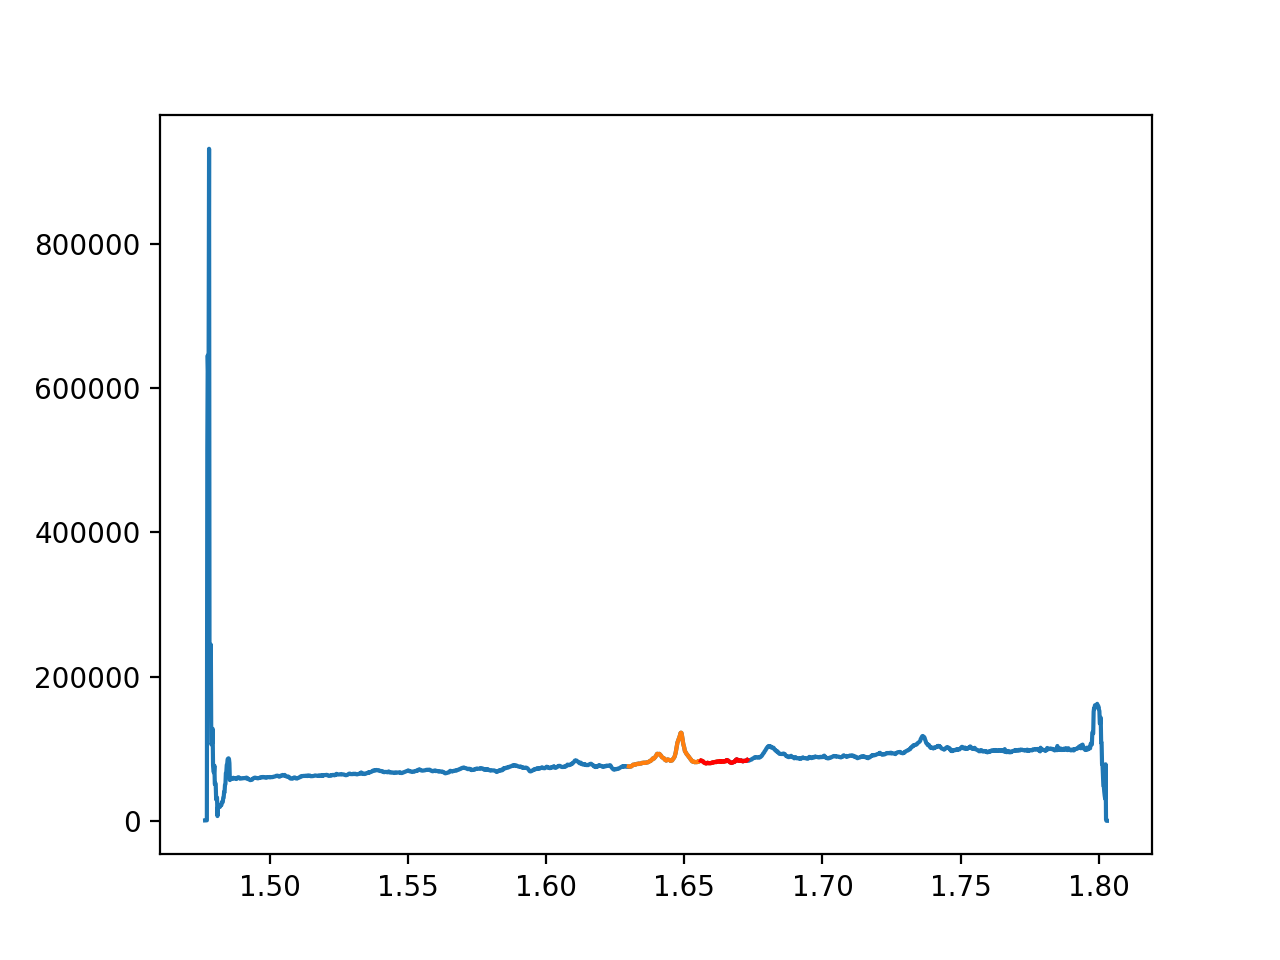

In [8]:

#define the wavelength region where you want to remove the continuum very accurately.  
# Here we select a region that includes the emission line
# wavelength plus a range of continuum around it.  
# Determine these limits by investigating the flux in the above plot.  Read
# the wavelength values off of the plot information at the lower right.

wave_emission_limit1 = 1.630
wave_emission_limit2 = 1.665

# Here we define a spectral range where we will use the
# flux to generate a continuum model.  The flux shape in this
# AGN is quite linear around the redward emission, so we will use only a 
# short segment of the spectrum on the red side of the emission 
# feature.
# We again determine these values by investigating the wavelengths in the
# above plot window.

continuum_limit1 = 1.656
continuum_limit2 = 1.673
  
#Define the wavelength region around the emission - indices
wavemin = (np.abs(wave-wave_emission_limit1)).argmin()
wavemax = (np.abs(wave-wave_emission_limit2)).argmin()

# Define the wavelength region used to fit the continuum flux level  - indices.
continuummin = (np.abs(wave-continuum_limit1)).argmin()
continuummax = (np.abs(wave-continuum_limit2)).argmin()

#show the region used for the emission line and continuum fit.  Alter the wavelengths 
# above if this doesn't look good.
plt.figure(1)
plt.plot(wave,flux1)
plt.plot(wave[wavemin:wavemax],flux1[wavemin:wavemax])
plt.plot(wave[continuummin:continuummax],flux1[continuummin:continuummax],color='r')
plt.show()



 For this particular dataset, this continuum region looks very good.
 if you have a more structured continuum you can define additional
 regions and append them into a larger set of wave / flux arrays to 
 derive a more accurate fit in the below poly-fit analysis.

In [9]:
# Use cubeviz to look at the data in the cube.  Here, we load the app.

app = Application(configuration='cubeviz')
app


Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

In [10]:

# Here, we load the data into the cubeviz app.
cube_file= 'NGC4151_Hband.fits'
app.load_data(cube_file)
 

 [astropy.io.fits.verify]




### Note: You must do these steps to load and select the data in cubeviz in order
### for the next cells to work correctly.

Set the cubeviz visualization panel to view our cube by selecting it in the
data (gear) icon.

In the same way, select the datacube in the spectral viewer at the bottom of the cubeviz pane.
This is the same cube-summed 1-D spectrum that we plotted above. 

In the datacube viewing panel, you can also select the 'layer' tab in the gear (data) icon and change 
display scaling.  Decreasing the maximum display value by 10x brings out the low level extended emission
in this dataset.  Data from slice ~1060 to ~1080 shows the extended [Fe II] emission.  

In [11]:
# show the 1-D spectrum.
app.get_viewer('spectrum-viewer').show()


Html(children=[Toolbar(children=[ToolbarItems(children=[BasicJupyterToolbar(borderless=True, children=[Tooltip…

In [12]:
# grab the collapsed spectrum.
spec_input = app.get_data_from_viewer('spectrum-viewer')


/Users/tbeck/anaconda3/envs/astroconda/lib/python3.7/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/tbeck/anaconda3/envs/astroconda/lib/python3.7/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/tbeck/anaconda3/envs/astroconda/lib/python3.7/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

Use the flux viewer in cubeviz to extract a spectrum located at the central AGN position.
It should show in the above spectral viewer, too.

/Users/tbeck/anaconda3/envs/astroconda/lib/python3.7/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result


<IPython.core.display.Javascript object>


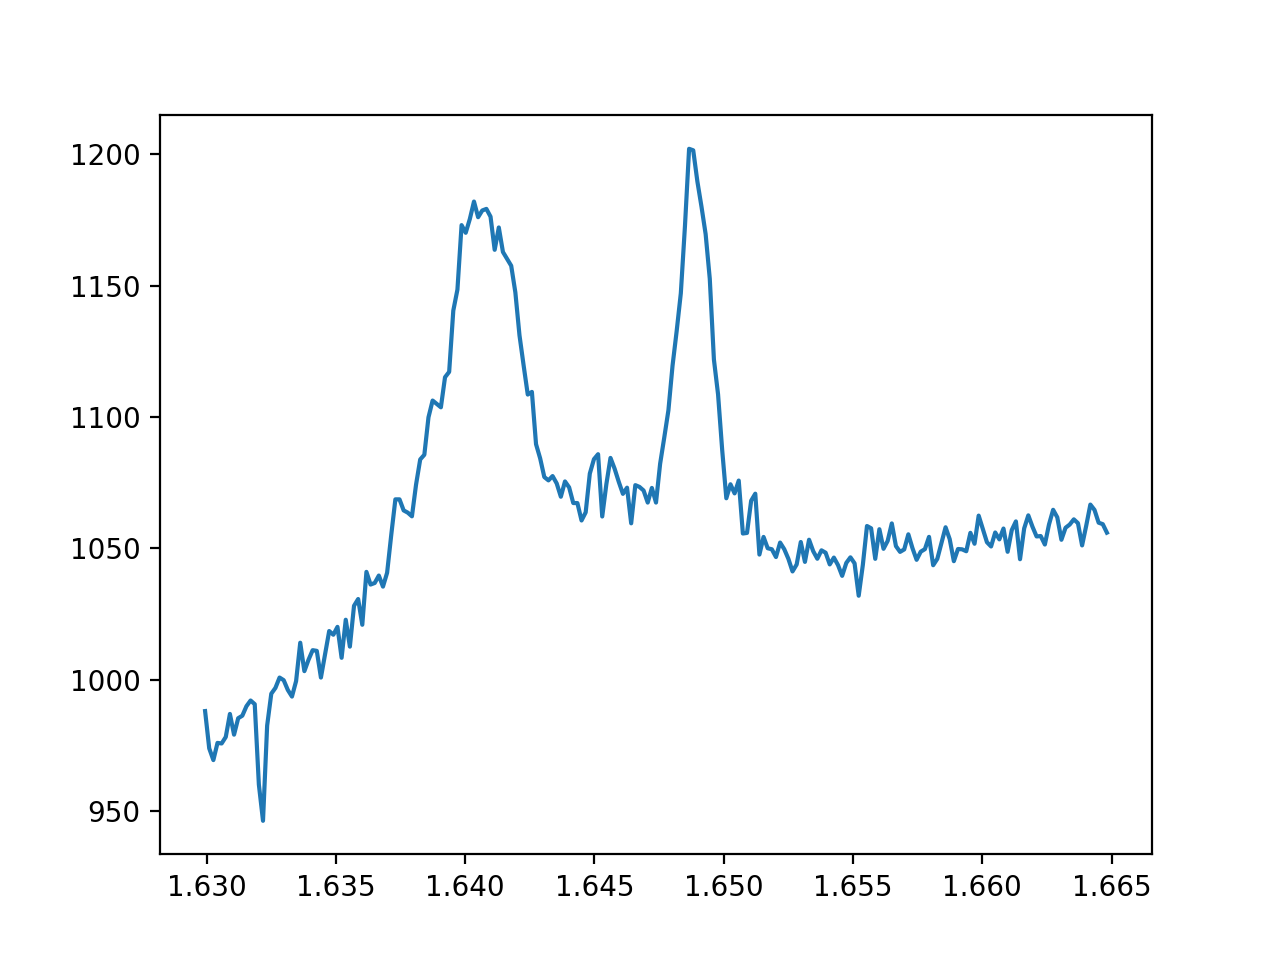

In [13]:
# Grab the layer spectrum that corresponds to the central AGN position.

spec_agn = app.get_data_from_viewer('spectrum-viewer', 'Subset 1')
spec_agn

# plot the 1-D spectrum of this smaller sub-region.
plt.figure(2)
plt.plot(wave[wavemin:wavemax],spec_agn.flux[wavemin:wavemax])
plt.show()


Now, use the flux viewer to make two more spectra at two positions associated with the outflow emission in [Fe II].

/Users/tbeck/anaconda3/envs/astroconda/lib/python3.7/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result
/Users/tbeck/anaconda3/envs/astroconda/lib/python3.7/site-packages/glue/core/data.py:1803: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  full_result[result_slices] = result


<IPython.core.display.Javascript object>


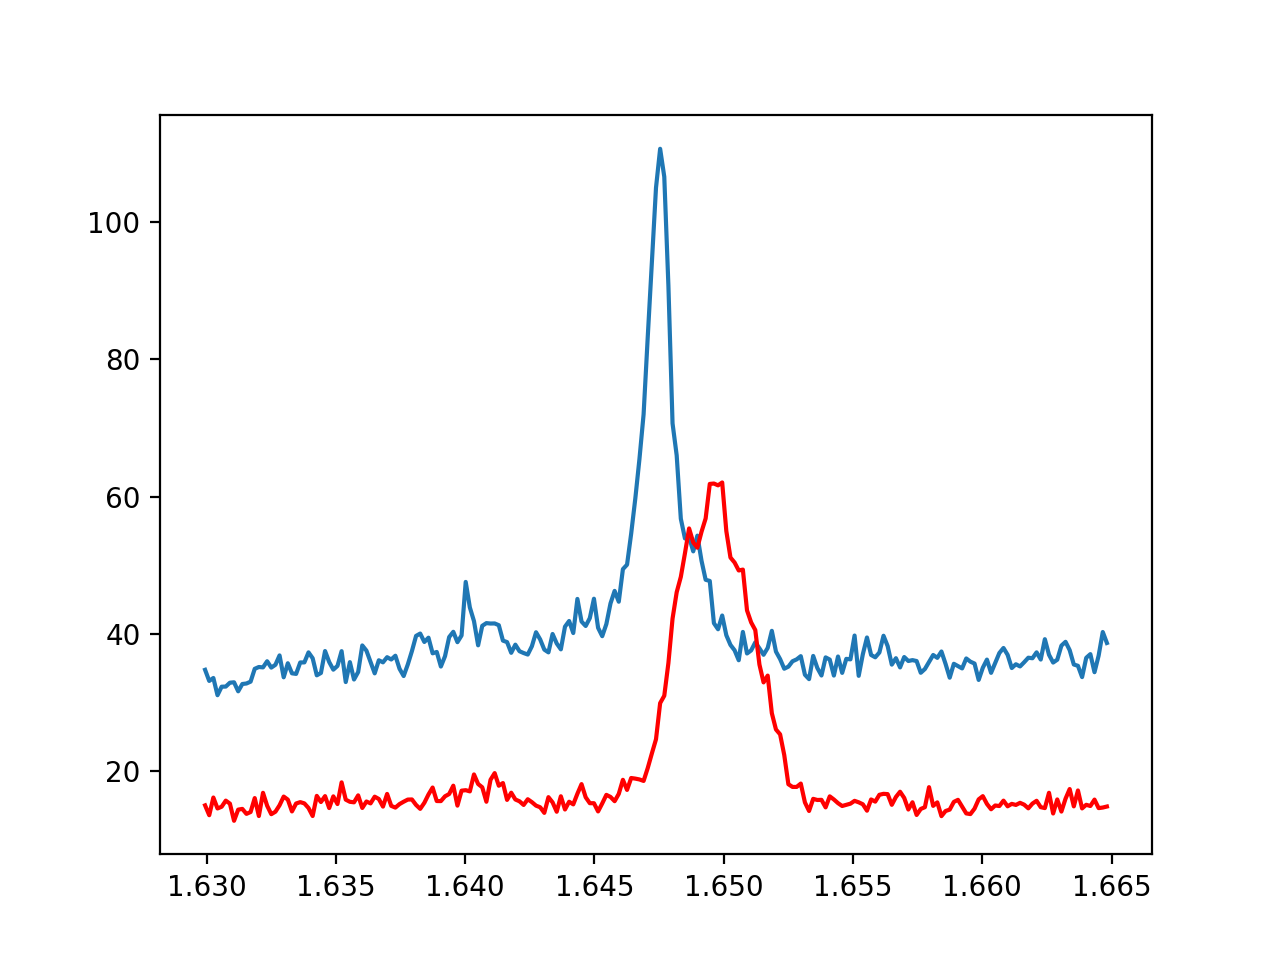

In [14]:

#grab the outflow spectra from the spectral viewer window.

spec_feii_red = app.get_data_from_viewer('spectrum-viewer', 'Subset 2')
spec_feii_red

spec_feii_blue = app.get_data_from_viewer('spectrum-viewer', 'Subset 3')
spec_feii_blue

#plot a zoomed view of the spectra grabbed from cubeviz

# plot the 1-D redshifted outflow spectrum.
plt.figure(3)
plt.plot(wave[wavemin:wavemax],spec_feii_blue.flux[wavemin:wavemax])
plt.show()

# plot the 1-D spectrum blueshifted outflow spectrum.
plt.figure(3)
plt.plot(wave[wavemin:wavemax],spec_feii_red.flux[wavemin:wavemax],color='r')
plt.show()



<IPython.core.display.Javascript object>


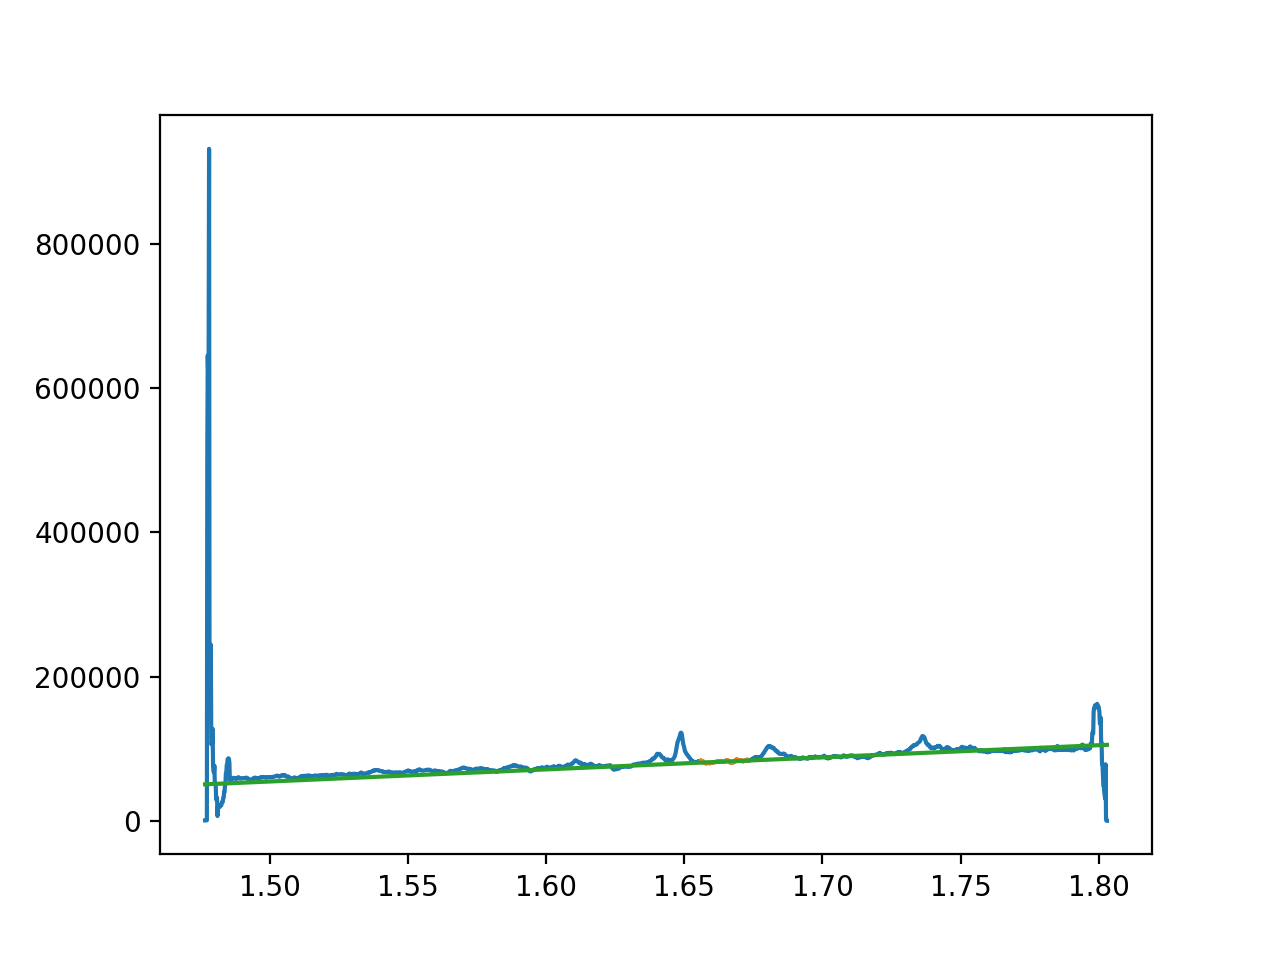

In [15]:

#demonstration of a linear fit to the continuum flux level
# this method uses simple functions in numpy to fit the continuum. 

cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
fitval = np.poly1d(cont_fit)
continuum = fitval(wave)

plt.figure(4)
plt.plot(wave,flux1)
plt.show()

plt.figure(4)
plt.plot(wave[continuummin:continuummax],flux1[continuummin:continuummax])
plt.show()

plt.figure(4)
plt.plot(wave,continuum)
plt.show()


<IPython.core.display.Javascript object>


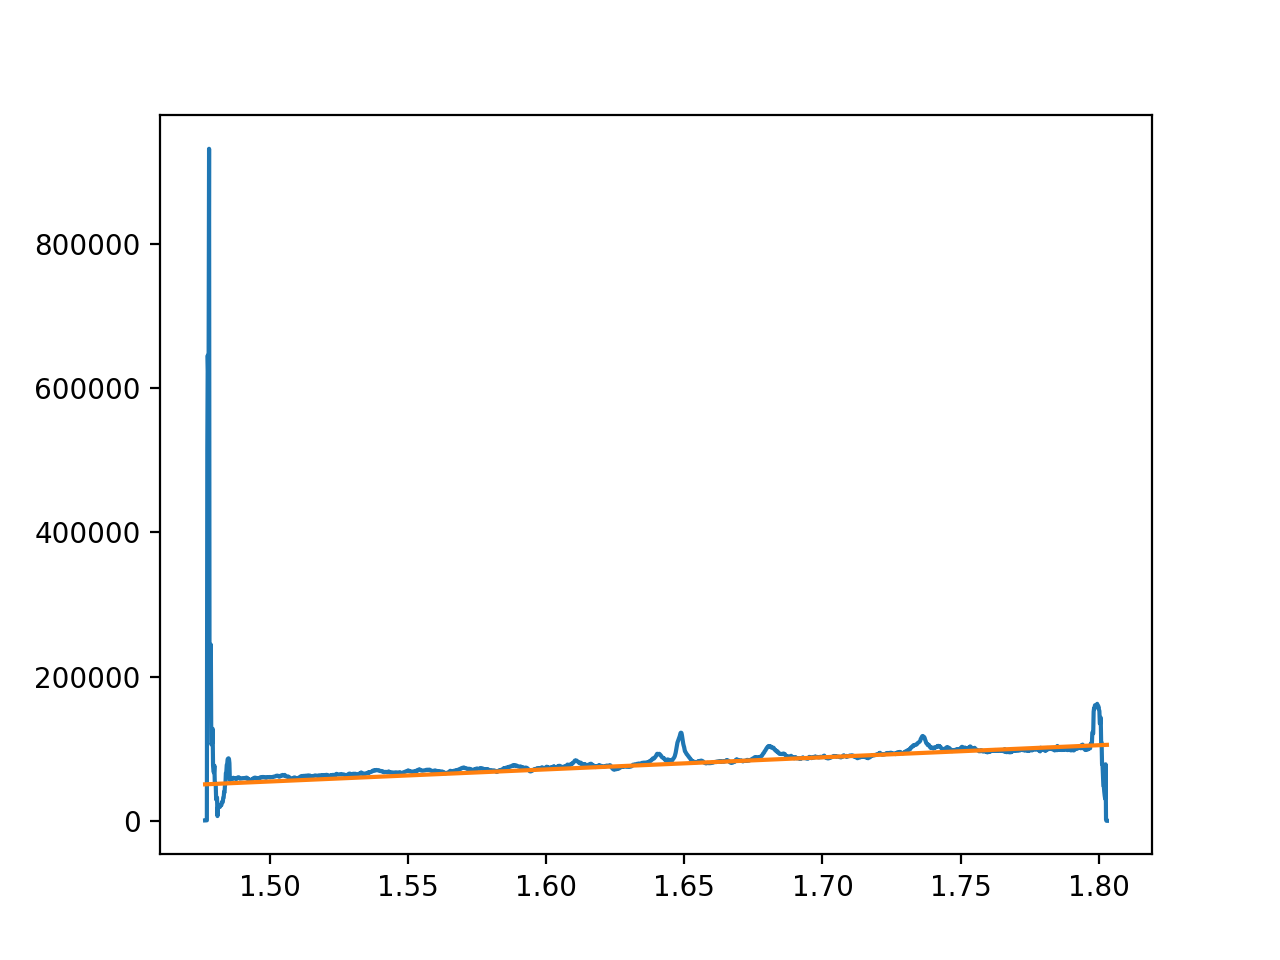

In [20]:
# That looks pretty good.

# Continued demonstration of a linear fit to the continuum flux level
# This method uses the specutils and modeling packages available
# in astropy.  It does the same thing as the prior cell, but in an astropy 
# spectral format.

# Here we use the polynomial routine to do a linear fit - this is so it's easy
# to update the fit order, if necessary.

full_spectrum=Spectrum1D(
    flux=flux1* u.Unit('count'), spectral_axis=wave* u.micron)

# Make Spectrum1D specutils version of data for the continuum segment.
spectrum = Spectrum1D(
    flux=flux1[continuummin:continuummax]*u.Unit('count'),
    spectral_axis=wave[continuummin:continuummax]*u.micron)

# Make an empty model with no initial guess of the coefficients
# If guessing make sure to only pass values (no units)
m = models.Polynomial1D(degree=1) # You can place a guess by setting c0 and c1
# Fit model and save fitted model containing the fitted params
fitted_model = fit_lines(spectrum, m)
# Just to showcase how to access the fitted params
cont_fit = [fitted_model.c1.value, fitted_model.c0.value]

# notice I dont have to use cont_fit to get my continuum
# I just call the model with my spectral values
continuum = fitted_model(full_spectrum.spectral_axis)

#plot the results - identical to above numpy code - looks good.
plt.figure(5)
plt.plot(wave,flux1)
plt.show()

plt.figure(5)
plt.plot(wave,continuum)
plt.show()


In [21]:
#Make a datacube that has the continuum flux level subtracted off.
# then make another datacube that is only the continuum flux, to serve
# as a PSF model to correct out the bright, central HI features.

# Here I'm using the numpy functions for continuum fitting and subtraction.

# This is done in nested for loops, looping over the spatial axes in the cube.

start_time = time.time()

cont_sub_cube=np.zeros((nz,ny,nx))
cont_psf_cube=np.zeros((nz,ny,nx))

for i in range(1, nx-2):
    for j in range(1, ny-2):
        flux1 = cube[:,j,i]      
        cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
        fitval = np.poly1d(cont_fit)
        continuum = fitval(wave)        
        cont_sub_cube[:,j,i]= flux1 - continuum
        cont_psf_cube[:,j,i]= continuum 

# make an appropriate header for the output images
header_image = header_cube
del header_image['CDELT3']
del header_image['CRVAL3']
del header_image['CRPIX3']
del header_image['MODE']
header_image['NAXIS'] = 2

fits.writeto('NGC4151_Hband_ContinuumSubtract.fits', cont_sub_cube, header_cube, overwrite=True)
fits.writeto('NGC4151_Hband_ContinuumPSF.fits', cont_psf_cube, header_cube, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

print('Time count')
print("--- %s seconds ---" % (time.time() - start_time))


Continuum subtracted cube saved. PSF continuum cube saved.
Time count
--- 1.2841949462890625 seconds ---


In [ ]:
#use models polyfit instead of numpy to do the continuum fitting.  Use the poly fit options instead
# of line fitting so that you can change the order if necessary.

# This is done in nested for loops, looping over the RA, Dec axes in the cube.

# This is really slow...

start_time = time.time()

cont_sub_cube_specutils=np.zeros((nz,ny,nx))
cont_psf_cube_specutils=np.zeros((nz,ny,nx))

for i in range(1, nx-2):
    for j in range(1, ny-2):
        flux1 = Spectrum1D(flux = cube[:,j,i]* u.Unit('count'), spectral_axis=wave* u.micron)
        m = models.Polynomial1D(degree=1)
        fitted_model = fit_lines(flux1[continuummin:continuummax], m)
        cont_fit = [fitted_model.c1.value, fitted_model.c0.value]
        continuum = fitted_model(flux1.spectral_axis)
        cont_sub_cube_specutils[:,j,i]= flux1.flux - continuum
        cont_psf_cube_specutils[:,j,i]= continuum

print('Done')

print('Time count')
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
# Now, let's take a look at the emission line in the continuum
# subtracted cube.
flux1=np.sum(cont_sub_cube, axis=(1,2))

# plot the 1-D spectrum of the full continuum subtracted cube
plt.figure(6)
plt.plot(wave[wavemin:wavemax],flux1[wavemin:wavemax])
plt.show()

# plot the 1-D spectrum of a single spaxel.
plt.figure(7)
plt.plot(wave[wavemin:wavemax],cont_sub_cube[wavemin:wavemax,30,30])
plt.show()


Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Gaussian1D(amplitude=106.06290861 ct, mean=1.64057284 micron, stddev=0.00172526 micron)>

    [1]: <Gaussian1D(amplitude=33.20182016 ct, mean=1.64787376 micron, stddev=0.00285631 micron)>

    [2]: <Gaussian1D(amplitude=100.5315968 ct, mean=1.6488724 micron, stddev=0.00055342 micron)>
Parameters:
       amplitude_0           mean_0      ...      mean_2             stddev_2      
            ct               micron      ...      micron              micron       
    ------------------ ----------------- ... ---------------- ---------------------
    106.06290860999303 1.640572841153526 ... 1.64887239532708 0.0005534204049397833


<IPython.core.display.Javascript object>


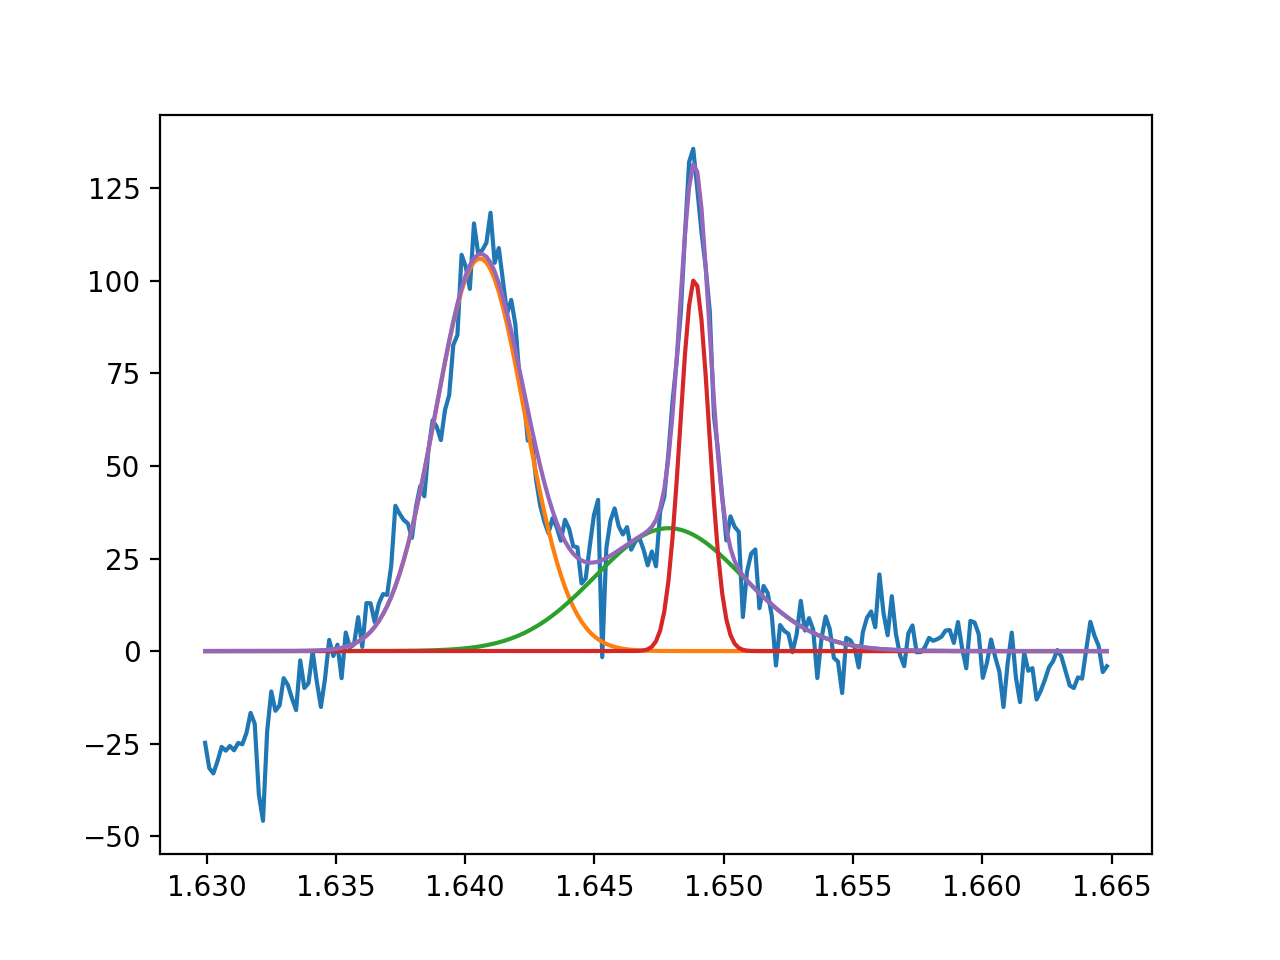

In [22]:
# Turn the spectrum at the central location into a spectrum as
# needed for use with specutils.  Investigate an initial fit to the
# Br 12 emission feature, which is pesky and nearby in wavelength
# to our target [Fe II] emission.

#zoom in wavelength into the region of interest, create subcube and subwave arrays.
flux=(cont_sub_cube[wavemin:wavemax,30,30])
minwave=wave[wavemin:wavemax]

# put the flux spectrum into the spec utils expected format.
spectrum = Spectrum1D(flux=(flux)*u.Unit('count'),spectral_axis=minwave*u.micron)

#define the fit the line for the Brackett emission (position was found by hand @ pix 1023):
# the central emission is best fit by two gaussian components: one @ br12, one @ [Fe II].
l1 = models.Gaussian1D(amplitude=(flux[1023-wavemin])*u.Unit('count'),mean=minwave[1023-wavemin]*u.micron,stddev=0.0009*u.micron)
l2 = models.Gaussian1D(amplitude=(flux[emission_line_index-wavemin])*u.Unit('count'),mean=minwave[emission_line_index-wavemin]*u.micron,stddev=0.005*u.micron)
#define and fit the line for the outflow [Fe II] emission:
l3 = models.Gaussian1D(amplitude=(flux[emission_line_index-wavemin])*u.Unit('count'),mean=minwave[emission_line_index-wavemin]*u.micron,stddev=0.0008*u.micron)

#run the lfit
lfit = fit_lines(spectrum,l1+l2+l3)
#make the yfit
y_fit = lfit(minwave*u.micron)

print(lfit)

lineflux = (lfit[0](minwave*u.micron))
linemodel = Spectrum1D(spectral_axis=minwave*u.micron, flux=lineflux*u.Unit('count'))

component1=lfit[0](minwave*u.micron)
component2=lfit[1](minwave*u.micron)
component3=lfit[2](minwave*u.micron)

plt.figure(8)
plt.plot(minwave,flux)
plt.plot(minwave,component1)
plt.plot(minwave,component2)
plt.plot(minwave,component3)
plt.plot(minwave,component1+component2+component3)
plt.show()

#we want to isolate just the [Fe II] outflow emission, so subtract off the central compact flux sources
central_flux_model_only=component1+component2


Continuum and Brackett subtracted cube saved.  Full model cube saved.


<IPython.core.display.Javascript object>


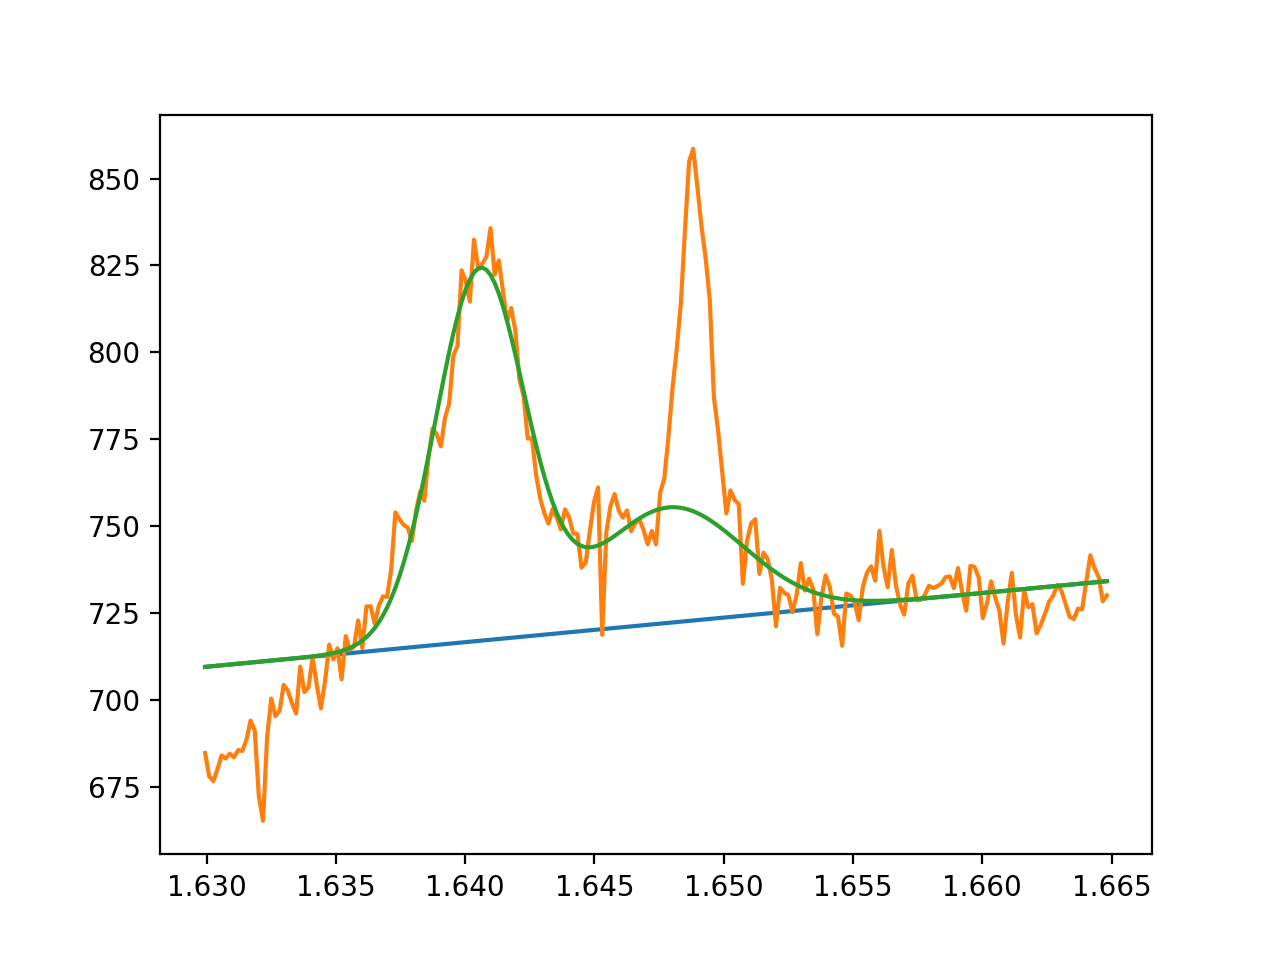

In [23]:
# Wow, that multi-component fit looks great.  Good deal.

#now we're going to use the continuum psf cube saved in a prior cell 
# with the Brackett model created in the above cell to create a full
# 3-D model of the central emission that isn't caused by the outflow [Fe II].

continuum_subcube=cont_psf_cube[wavemin:wavemax,:,:]
nz, ny, nx = continuum_subcube.shape

model_cube=np.zeros([nz,ny,nx])

#construct the scaled Brackett flux model
model_cube[0,:,:]=continuum_subcube[0,:,:]*(central_flux_model_only[0]/continuum_subcube[0,30,30])
for i in range(1, nz-2):
    model_image=0.5*continuum_subcube[i,:,:]+0.25*(continuum_subcube[i-1,:,:]+continuum_subcube[i+1,:,:])
    model_cube[i,:,:]=model_image*(central_flux_model_only[i]/continuum_subcube[i,30,30])
model_cube[nz-1,:,:]=continuum_subcube[nz-1,:,:]*(central_flux_model_only[nz-1]/continuum_subcube[nz-1,30,30])

# the full model of the AGN central emission is the continuum plus Brackett line.
full_model= continuum_subcube+model_cube

# subtract the model to create the final cube where the [Fe II] emission
# is isolated.
final_sub_cube=cube[wavemin:wavemax,:,:]-full_model

# make an appropriate header for the output sub-cube
header_cube_small = header_cube
header_cube_small['CRVAL3'] = wavemin

# Save the .fits data sub-cube that has the continuum and Br model subtracted off of the
# [Fe II] emission, and the datacube that is the continuum+Br model.
fits.writeto('NGC4151_Hband_FinalSubtract.fits', final_sub_cube, header_cube_small, overwrite=True)
fits.writeto('NGC4151_Hband_ContinuumandBrackettModel.fits', full_model, header_cube_small, overwrite=True)
print('Continuum and Brackett subtracted cube saved.  Full model cube saved.')

#make a plot of the central spectrum, the full model and the continuum.
plt.figure(9)
plt.plot(minwave,continuum_subcube[:,30,30])
plt.plot(minwave,cube[wavemin:wavemax,30,30])
plt.plot(minwave,full_model[:,30,30])
plt.show()


In [ ]:

# Note trying to load a second datacube into cubeviz within the same notebook does bad things to the 
# data interaction.  Must interact with only one cube at a time in the notebook cubeviz interface.
